In [1]:
# -------------------------------------------------------------------------------------------------------------------
# Course name - Exploratory data analysis
# Course code - DSC530
# Week 11 assignment
# Script name - Shekhar530Week11.ipynb
# Creator - Manish Shekhar
# Date created - Feb 20th - Feb 27th 2023
# -------------------------------------------------------------------------------------------------------------------

#### Exercise 18-1: In NSFG Cycles 6 and 7, the variable cmdivorcx contains the date of divorce for the respondent’s first marriage, if applicable, encoded in century-months.

#### Compute the duration of marriages that have ended in divorce, and the duration, so far, of marriages that are ongoing. Estimate the hazard and survival curve for the duration of marriage.

#### Use resampling to take into account sampling weights, and plot data from several resamples to visualize sampling error. Consider dividing the respondents into groups by decade of birth, and possibly by age at first marriage.

In [32]:
# downloading thinstats and thinkplot

from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")

In [33]:
# importing required libraries
import thinkstats2
import thinkplot

In [34]:
import numpy as np
import pandas as pd

In [35]:
# installing empiricaldist
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

In [ ]:
# Download the respondent data
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dct")
download(
    "https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dat.gz"
)

download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemResp.dct")
download(
    "https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemResp.dat.gz"
)

In [36]:
import nsfg
resp6 = nsfg.ReadFemResp()

In [37]:
# cleanup data
resp6.cmmarrhx.replace([9997, 9998, 9999], np.nan, inplace=True)
resp6["agemarry"] = (resp6.cmmarrhx - resp6.cmbirth) / 12.0
resp6["age"] = (resp6.cmintvw - resp6.cmbirth) / 12.0

In [38]:
# extract complete, which is the age at marriage for women who have been married, and ongoing, which is the age at interview for women who have not
complete = resp6[resp6.evrmarry == 1].agemarry.dropna()
ongoing = resp6[resp6.evrmarry == 0].age

In [39]:
# To generate survivial curves for each birth cohort, we need more data, which we can get by combining data from several NSFG cycles.
download(
    "https://github.com/AllenDowney/ThinkStats2/raw/master/code/1995FemRespData.dat.gz"
)
download(
    "https://github.com/AllenDowney/ThinkStats2/raw/master/code/2006_2010_FemRespSetup.dct"
)
download(
    "https://github.com/AllenDowney/ThinkStats2/raw/master/code/2006_2010_FemResp.dat.gz"
)

In [40]:
# Survival is the complementary of cdf
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/survival.py")

In [42]:
# diving the data by birth cohorts
import survival

resp5 = survival.ReadFemResp1995()
resp6 = survival.ReadFemResp2002()
resp7 = survival.ReadFemResp2010()

In [43]:
resps = [resp5, resp6, resp7]

In [44]:
# additional data cleansing
def CleanData(resp):
    """Cleans respondent data.

    resp: DataFrame
    """
    resp.cmdivorcx.replace([9998, 9999], np.nan, inplace=True)

    resp["notdivorced"] = resp.cmdivorcx.isnull().astype(int)
    resp["duration"] = (resp.cmdivorcx - resp.cmmarrhx) / 12.0
    resp["durationsofar"] = (resp.cmintvw - resp.cmmarrhx) / 12.0

    month0 = pd.to_datetime("1899-12-15")
    dates = [month0 + pd.DateOffset(months=cm) for cm in resp.cmbirth]
    resp["decade"] = (pd.DatetimeIndex(dates).year - 1900) // 10

In [45]:
CleanData(resp6)
married6 = resp6[resp6.evrmarry == 1]

CleanData(resp7)
married7 = resp7[resp7.evrmarry == 1]

In [46]:
# function to resample 
def ResampleDivorceCurve(resps):
    """Plots divorce curves based on resampled data.

    resps: list of respondent DataFrames
    """
    for _ in range(11):
        samples = [thinkstats2.ResampleRowsWeighted(resp) for resp in resps]
        sample = pd.concat(samples, ignore_index=True)
        PlotDivorceCurveByDecade(sample, color="#225EA8", alpha=0.1)

    thinkplot.Show(xlabel="years", axis=[0, 28, 0, 1])

In [48]:
# function to resample divorce data per cohort (by birth decade)
def ResampleDivorceCurveByDecade(resps):
    """Plots divorce curves for each birth cohort.

    resps: list of respondent DataFrames
    """
    for i in range(41):
        samples = [thinkstats2.ResampleRowsWeighted(resp) for resp in resps]
        sample = pd.concat(samples, ignore_index=True)
        groups = sample.groupby("decade")
        if i == 0:
            survival.AddLabelsByDecade(groups, alpha=0.7)

        EstimateSurvivalByDecade(groups, alpha=0.1)

    thinkplot.Config(xlabel="Years", ylabel="Fraction undivorced", axis=[0, 28, 0, 1])

In [49]:
# Estimate survival by decade / per cohort
def EstimateSurvivalByDecade(groups, **options):
    """Groups respondents by decade and plots survival curves.

    groups: GroupBy object
    """
    thinkplot.PrePlot(len(groups))
    for name, group in groups:
        _, sf = EstimateSurvival(group)
        thinkplot.Plot(sf, **options)

In [50]:
# function to estimate survival
def EstimateSurvival(resp):
    """Estimates the survival curve.

    resp: DataFrame of respondents

    returns: pair of HazardFunction, SurvivalFunction
    """
    complete = resp[resp.notdivorced == 0].duration.dropna()
    ongoing = resp[resp.notdivorced == 1].durationsofar.dropna()

    hf = survival.EstimateHazardFunction(complete, ongoing)
    sf = hf.MakeSurvival()

    return hf, sf

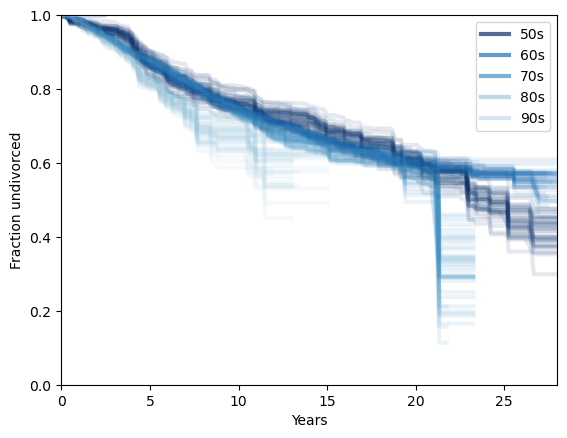

In [51]:
# resample divorce by decade and plot each corts survival function
import warnings
warnings.filterwarnings('ignore')

ResampleDivorceCurveByDecade([married6, married7])